In [1]:
import sys, os
print("Python:", sys.version)
print("Working dir:", os.getcwd())

import json
import math
import time
import platform
from pprint import pprint

# Check memory/CPU
try:
    import psutil
    print("CPUs:", psutil.cpu_count(logical=True))
    vm = psutil.virtual_memory()
    print("Total RAM (GB):", round(vm.total/1024**3,2))
except Exception as e:
    print("psutil not available:", e)

print("\nIf any pip installs failed, install them manually (conda/pip) and re-run this cell.")


Python: 3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
Working dir: /Users/Mathi
CPUs: 8
Total RAM (GB): 8.0

If any pip installs failed, install them manually (conda/pip) and re-run this cell.


In [2]:
# Cell 2: Locate CSV and inspect
import pandas as pd
DATA_PATH = "/Users/Mathi/Downloads/complaints.csv"   # <- Set this to the actual filename/path of your big CSV

# If file not found, print helpful message
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Place the CSV in the notebook folder or update DATA_PATH.")

# Read a tiny sample to detect column names and a few rows
df_head = pd.read_csv(DATA_PATH, nrows=5, low_memory=False, on_bad_lines='skip', encoding='utf-8')
print("Columns detected:")
print(df_head.columns.tolist())
print("\nFirst rows:")
display(df_head.head(3))


Columns detected:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

First rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-09-18,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",TX,77077,NaN,NaN,Web,2025-09-18,In progress,Yes,NaN,16016736
2,2025-09-04,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,IL,60619,NaN,NaN,Web,2025-09-04,In progress,Yes,NaN,15722832


In [3]:
# Cell 3: Auto-detect text & product columns
possible_text_cols = [
    'consumer_complaint_narrative',
    'Consumer complaint narrative',
    'complaint_what_happened',
    'complaint_what_happened',
    'complaint_what_happend', # typos in some datasets
    'description',
    'description_of_issue',
    'what_happened',
    'consumer_complaint',
    'narrative'
]

possible_product_cols = [
    'product', 'Product', 'product_name', 'product_type'
]

cols = [c.lower() for c in df_head.columns.tolist()]
col_map = {c.lower(): c for c in df_head.columns.tolist()}

def find_first(candidates):
    for cand in candidates:
        if cand.lower() in col_map:
            return col_map[cand.lower()]
    # fallback: find any column containing keywords
    for name in col_map:
        for cand in candidates:
            if cand.lower() in name:
                return col_map[name]
    return None

text_col = find_first(possible_text_cols)
product_col = find_first(possible_product_cols)

print("Auto-detected text_col:", text_col)
print("Auto-detected product_col:", product_col)

if text_col is None or product_col is None:
    print("\nCould not detect automatically. Here are all columns again; please edit DATA_TEXT_COL and DATA_PRODUCT_COL variables manually and re-run cell:")
    print(df_head.columns.tolist())
else:
    print("\nLooks good. We'll use these columns. If you'd like to override, edit the variables below and re-run.")
    
# If you want to override:
DATA_TEXT_COL = text_col        # edit if needed
DATA_PRODUCT_COL = product_col  # edit if needed

print("\nFinal text col:", DATA_TEXT_COL)
print("Final product col:", DATA_PRODUCT_COL)


Auto-detected text_col: Consumer complaint narrative
Auto-detected product_col: Product

Looks good. We'll use these columns. If you'd like to override, edit the variables below and re-run.

Final text col: Consumer complaint narrative
Final product col: Product


In [4]:
# Cell 4: Build a stratified sample CSV by streaming
import pandas as pd
from tqdm.auto import tqdm
import re

# === PARAMETERS ===
DATA_PATH = DATA_PATH  # from earlier cell
OUT_SAMPLE_CSV = "sample_complaints.csv"
SAMPLES_PER_CLASS = 5000   # <-- adjust: 2000, 5000, 10000 depending on how much you want to sample
CHUNKSIZE = 200000         # number of rows to read per chunk (tuneable)
TEXT_COL = DATA_TEXT_COL
PRODUCT_COL = DATA_PRODUCT_COL

# Define mapping rules (substring matching)
target_map = {
    0: ["credit reporting", "credit report", "credit reporting, repair, or other", "credit reporting/repair"],
    1: ["debt collection", "debt-collection", "debt collection/collection"],
    2: ["consumer loan", "consumer loans", "consumer loan/vehicle loan", "personal loan"],
    3: ["mortgage", "home mortgage", "home mortgage loan"]
}

# prepare storage counters and buffer
counts = {k: 0 for k in target_map}
buffers = {k: [] for k in target_map}
selected_cols = [PRODUCT_COL, TEXT_COL]

def classify_product(prod):
    if pd.isna(prod):
        return None
    p = str(prod).lower()
    for tgt, substrs in target_map.items():
        for s in substrs:
            if s in p:
                return tgt
    return None

total_rows = 0
reader = pd.read_csv(DATA_PATH, chunksize=CHUNKSIZE, low_memory=False, usecols=lambda x: x in selected_cols, on_bad_lines='skip', encoding='utf-8')

pbar = tqdm(desc="Sampling chunks")
for chunk in reader:
    total_rows += len(chunk)
    # drop rows with missing text
    chunk = chunk.dropna(subset=[TEXT_COL])
    # classify
    chunk['__target'] = chunk[PRODUCT_COL].apply(classify_product)
    # iterate rows that match a target and add to buffer if not full
    for tgt in target_map:
        if counts[tgt] >= SAMPLES_PER_CLASS:
            continue
        matched = chunk[chunk['__target'] == tgt]
        if matched.empty:
            continue
        need = SAMPLES_PER_CLASS - counts[tgt]
        take = matched.iloc[:need]
        buffers[tgt].append(take[[PRODUCT_COL, TEXT_COL]])
        counts[tgt] += len(take)
    # stop early if all done
    if all(c >= SAMPLES_PER_CLASS for c in counts.values()):
        break
    pbar.update(1)
pbar.close()

print("Collected counts per class:", counts)

# concatenate buffers and write sample CSV
dfs = []
for tgt in buffers:
    if buffers[tgt]:
        tmp = pd.concat(buffers[tgt], ignore_index=True)
        tmp['target'] = tgt
        dfs.append(tmp)
if not dfs:
    raise RuntimeError("No rows found for target classes. Check product column values and mapping rules.")

sample_df = pd.concat(dfs, ignore_index=True)
print("Final sample shape:", sample_df.shape)
# Shuffle
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Write out so we can reuse
sample_df.to_csv(OUT_SAMPLE_CSV, index=False)
print(f"Saved sample CSV to {OUT_SAMPLE_CSV}.")


Sampling chunks: 0it [00:00, ?it/s]

Collected counts per class: {0: 5000, 1: 5000, 2: 5000, 3: 5000}
Final sample shape: (20000, 3)
Saved sample CSV to sample_complaints.csv.


Sample loaded: (20000, 3)

Class distribution:
target
2    5000
0    5000
1    5000
3    5000
Name: count, dtype: int64

Text length (chars) stats:
count    20000.000000
mean      1131.575050
std       1254.798978
min         13.000000
25%        420.000000
50%        800.000000
75%       1437.000000
max      31163.000000
Name: text_len, dtype: float64

Top 30 frequent words (from 5k random samples):
[('xxxx', 54789), ('the', 41493), ('to', 33529), ('and', 26416), ('my', 19092), ('of', 18576), ('that', 14058), ('xx', 12792), ('was', 11244), ('in', 11180), ('this', 10820), ('on', 10512), ('they', 9778), ('not', 9525), ('for', 9434), ('have', 9224), ('is', 9206), ('with', 7764), ('me', 7745), ('credit', 7128), ('it', 6517), ('from', 5808), ('account', 5568), ('as', 5560), ('be', 4848), ('loan', 4840), ('or', 4577), ('information', 4153), ('payment', 4101), ('report', 3938)]


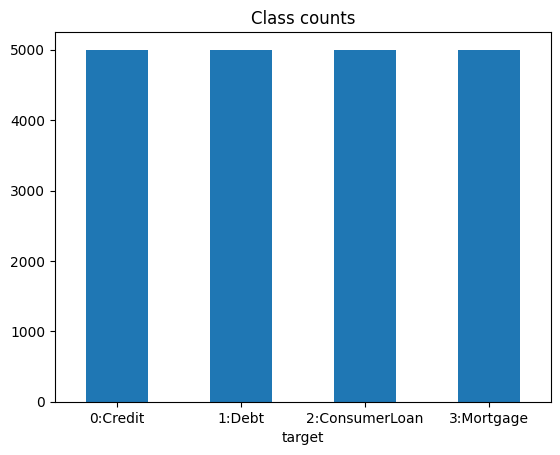

In [5]:
# Cell 5: EDA on sample
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

SAMPLE_CSV = "sample_complaints.csv"
df = pd.read_csv(SAMPLE_CSV)
print("Sample loaded:", df.shape)
print("\nClass distribution:")
print(df['target'].value_counts())

# Text length stats
df['text_len'] = df[TEXT_COL].astype(str).str.len()
print("\nText length (chars) stats:")
print(df['text_len'].describe())

# Top words (quick)
def simple_tokenize(text):
    toks = re.findall(r'\b[a-zA-Z]{2,}\b', str(text).lower())
    return toks

all_words = Counter()
for t in df[TEXT_COL].astype(str).sample(n=min(5000, len(df)), random_state=42):
    all_words.update(simple_tokenize(t))
print("\nTop 30 frequent words (from 5k random samples):")
print(all_words.most_common(30))

# plot class distribution
ax = df['target'].value_counts().sort_index().plot(kind='bar', title='Class counts')
ax.set_xticklabels(['0:Credit','1:Debt','2:ConsumerLoan','3:Mortgage'], rotation=0)
plt.show()


In [6]:
# Cell 6: Train/test Split and TF-IDF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Download nltk punkt/wordnet if needed (first time)
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# 1) Split
X = df[TEXT_COL].astype(str)
y = df['target'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train / Test sizes:", X_train.shape, X_test.shape)

# 2) Simple cleaning function
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+',' ', s)                # remove urls
    s = re.sub(r'\S+@\S+',' ', s)               # remove emails
    s = re.sub(r'[^a-z0-9\s]', ' ', s)          # keep alphanum
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply cleaning lazily via tokenizer in vectorizer below (so we don't store extra columns)
# 3) Build TF-IDF vectorizer
tfidf = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=nltk.word_tokenize,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    max_features=50000
)

print("Fitting TF-IDF on training texts (this can take a while)...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


Train / Test sizes: (16000,) (4000,)
Fitting TF-IDF on training texts (this can take a while)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF shapes: (16000, 50000) (4000, 50000)



Training LogisticRegression (saga)...
Trained LR in 1.7s

Training SGDClassifier (log loss) ...
Trained SGD in 0.5s

=== Model: logreg ===
              precision    recall  f1-score   support

           0     0.8474    0.8610    0.8542      1000
           1     0.8254    0.8130    0.8191      1000
           2     0.8260    0.8590    0.8422      1000
           3     0.9531    0.9140    0.9331      1000

    accuracy                         0.8618      4000
   macro avg     0.8630    0.8618    0.8621      4000
weighted avg     0.8630    0.8618    0.8621      4000

Macro F1: 0.8621490634405521


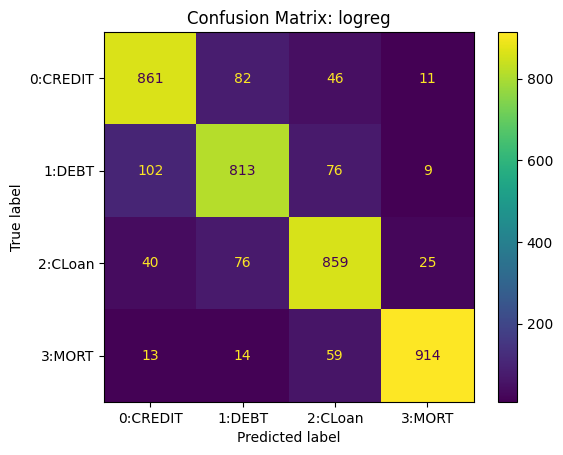


=== Model: sgd ===
              precision    recall  f1-score   support

           0     0.8297    0.8670    0.8479      1000
           1     0.8362    0.7860    0.8103      1000
           2     0.8153    0.8520    0.8333      1000
           3     0.9423    0.9140    0.9279      1000

    accuracy                         0.8548      4000
   macro avg     0.8559    0.8548    0.8549      4000
weighted avg     0.8559    0.8548    0.8549      4000

Macro F1: 0.8548504135521083


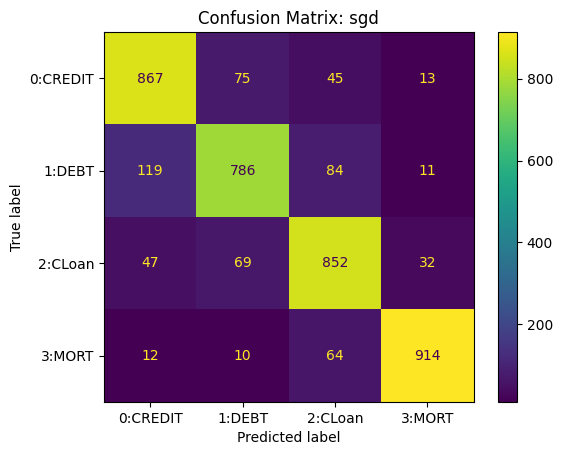

Saved tfidf_vectorizer.joblib and model_logreg.joblib (logreg).


In [8]:
# Cell 7: Train & compare models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import time
import joblib

models = {}

# Logistic Regression (saga) - works well with sparse input
print("\nTraining LogisticRegression (saga)...")
t0 = time.time()
lr = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', class_weight='balanced', n_jobs=-1)
lr.fit(X_train_tfidf, y_train)
t1 = time.time()
print(f"Trained LR in {t1-t0:.1f}s")
models['logreg'] = lr

# SGDClassifier (online, fast)
print("\nTraining SGDClassifier (log loss) ...")
t0 = time.time()
sgd = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-4, class_weight='balanced', n_jobs=-1)
sgd.fit(X_train_tfidf, y_train)
t1 = time.time()
print(f"Trained SGD in {t1-t0:.1f}s")
models['sgd'] = sgd

# Evaluate
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, m in models.items():
    preds = m.predict(X_test_tfidf)
    print(f"\n=== Model: {name} ===")
    print(classification_report(y_test, preds, digits=4))
    print("Macro F1:", f1_score(y_test, preds, average='macro'))
    # confusion matrix
    cm = confusion_matrix(y_test, preds, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(cm, display_labels=['0:CREDIT','1:DEBT','2:CLoan','3:MORT'])
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# Save best model & vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(models['logreg'], "model_logreg.joblib")
print("Saved tfidf_vectorizer.joblib and model_logreg.joblib (logreg).")


In [10]:
# Cell 8: Optional cross-validation (on subset to keep it fast)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

# We'll use a smaller subset for CV (e.g., 5000 samples) to save time
CV_SUBSET = 5000
if len(X_train) > CV_SUBSET:
    X_cv = X_train.sample(n=CV_SUBSET, random_state=42)
    y_cv = y_train.loc[X_cv.index]
else:
    X_cv, y_cv = X_train, y_train

pipeline = make_pipeline(tfidf, SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-4, class_weight='balanced'))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_cv, y_cv, scoring='f1_macro', cv=cv, n_jobs=-1)
print("3-fold CV macro F1 scores:", scores, "mean:", scores.mean())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3-fold CV macro F1 scores: [0.84527464 0.8506375  0.83196834] mean: 0.8426268247375518


In [11]:
# Cell 9: Load and predict example sentences
import joblib
tfidf = joblib.load("tfidf_vectorizer.joblib")
model = joblib.load("model_logreg.joblib")

samples = [
    "I was told my credit report has incorrect accounts and it ruined my credit score.",
    "I keep getting calls from a debt collector about a loan I paid years ago.",
    "I applied for a personal consumer loan but the company never disbursed the money.",
    "My mortgage servicer applied payments incorrectly and charged extra fees."
]
X_s = [s for s in samples]
X_s_tfidf = tfidf.transform(X_s)
preds = model.predict(X_s_tfidf)
print("Predictions:", preds)
label_map = {0:"Credit reporting/repair/other", 1:"Debt collection", 2:"Consumer Loan", 3:"Mortgage"}
for txt, p in zip(X_s, preds):
    print("->", p, label_map[p], "\n   ", txt)


Predictions: [0 1 2 3]
-> 0 Credit reporting/repair/other 
    I was told my credit report has incorrect accounts and it ruined my credit score.
-> 1 Debt collection 
    I keep getting calls from a debt collector about a loan I paid years ago.
-> 2 Consumer Loan 
    I applied for a personal consumer loan but the company never disbursed the money.
-> 3 Mortgage 
    My mortgage servicer applied payments incorrectly and charged extra fees.
